# K리그 패스 도착점 예측 - 모델링

## 개요
분위수 회귀(Quantile Regression)와 다중 모델 앙상블을 활용한 최종 모델입니다.

## 핵심 전략
1. **분위수 회귀 (q=0.5)**: 중앙값 예측으로 롱패스 이상치에 강건
2. **Y축 대칭 증강**: 데이터 2배 증가
3. **LightGBM + CatBoost 앙상블**: 모델 다양성 확보
4. **GroupKFold CV**: game_id 기준 분할로 일반화 성능 향상

## 최종 결과
- **CV**: 13.21
- **제출 점수**: 13.20

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# 상수
K = 6
FIELD_WIDTH = 68
N_FOLDS = 6

## 1. 데이터 준비

전처리 노트북과 동일한 과정을 거칩니다.

In [2]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test_index = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

test_events_list = []
for _, row in test_index.iterrows():
    path = row['path'].replace('./', '../data/')
    df_ep = pd.read_csv(path)
    df_ep['game_episode'] = row['game_episode']
    test_events_list.append(df_ep)
test_events = pd.concat(test_events_list, ignore_index=True)

train['is_train'] = 1
test_events['is_train'] = 0
events = pd.concat([train, test_events], ignore_index=True)
events['is_home'] = events['is_home'].astype(int)
events = events.sort_values(['game_episode', 'time_seconds', 'action_id']).reset_index(drop=True)

print(f'Train episodes: {train["game_episode"].nunique():,}')
print(f'Test episodes: {test_index["game_episode"].nunique():,}')

Train episodes: 15,435
Test episodes: 2,414


In [3]:
# 피처 생성 (전처리 노트북과 동일)
events['event_idx'] = events.groupby('game_episode').cumcount()
events['n_events'] = events.groupby('game_episode')['event_idx'].transform('max') + 1
events['ep_idx_norm'] = events['event_idx'] / (events['n_events'] - 1).clip(lower=1)
events['prev_time'] = events.groupby('game_episode')['time_seconds'].shift(1)
events['dt'] = (events['time_seconds'] - events['prev_time']).fillna(0.0)
events['dx'] = events['end_x'] - events['start_x']
events['dy'] = events['end_y'] - events['start_y']
events['dist'] = np.sqrt(events['dx']**2 + events['dy']**2)
events['speed'] = events['dist'] / events['dt'].replace(0, 1e-3)
events['angle'] = np.degrees(np.arctan2(events['dy'], events['dx']))
events['to_goal_dist'] = np.sqrt((105 - events['start_x'])**2 + (34 - events['start_y'])**2)
events['to_goal_angle'] = np.degrees(np.arctan2(34 - events['start_y'], 105 - events['start_x']))
events['x_zone'] = (events['start_x'] / (105/7)).astype(int).clip(0, 6)
events['lane'] = pd.cut(events['start_y'], bins=[0, 68/3, 2*68/3, 68], labels=[0, 1, 2], include_lowest=True).astype(int)
events['prev_start_x'] = events.groupby('game_episode')['start_x'].shift(1)
events['prev_start_y'] = events.groupby('game_episode')['start_y'].shift(1)
events['start_move_x'] = events['start_x'] - events['prev_start_x']
events['start_move_y'] = events['start_y'] - events['prev_start_y']
events['start_move_dist'] = np.sqrt(events['start_move_x']**2 + events['start_move_y']**2)
events['attacking_progress'] = events['start_move_x']
events['is_attacking_third'] = (events['start_x'] > 70).astype(int)
events['is_middle_third'] = ((events['start_x'] >= 35) & (events['start_x'] <= 70)).astype(int)
events['is_center_lane'] = ((events['start_y'] >= 20) & (events['start_y'] <= 48)).astype(int)
events['episode_duration'] = events.groupby('game_episode')['time_seconds'].transform('max') - events.groupby('game_episode')['time_seconds'].transform('min')

print('피처 생성 완료')

피처 생성 완료


In [4]:
# 메타 정보 및 타겟 누출 방지
all_last_events = events.groupby('game_episode', as_index=False).tail(1).copy()
ep_meta_all = all_last_events[['game_episode', 'game_id', 'team_id', 'is_home', 'period_id']].copy()
ep_meta_all = ep_meta_all.rename(columns={'team_id': 'final_team_id'})

events = events.merge(ep_meta_all[['game_episode', 'final_team_id']], on='game_episode', how='left')
events['is_final_team'] = (events['team_id'] == events['final_team_id']).astype(int)

events['last_idx'] = events.groupby('game_episode')['event_idx'].transform('max')
events['is_last'] = (events['event_idx'] == events['last_idx']).astype(int)
mask_last = events['is_last'] == 1
for col in ['end_x', 'end_y', 'dx', 'dy', 'dist', 'speed', 'angle']:
    events.loc[mask_last, col] = np.nan

events['type_name'] = events['type_name'].fillna('__NA__')
events['result_name'] = events['result_name'].fillna('__NA__')
le_type = LabelEncoder()
le_res = LabelEncoder()
events['type_id'] = le_type.fit_transform(events['type_name'])
events['res_id'] = le_res.fit_transform(events['result_name'])
events['team_id_enc'] = events['team_id'].astype(int)

print('메타 정보 처리 완료')

메타 정보 처리 완료


In [5]:
# Wide Format 변환
events['rev_idx'] = events.groupby('game_episode')['event_idx'].transform(lambda s: s.max() - s)
lastK = events[events['rev_idx'] < K].copy()

def assign_pos_in_K(df):
    df = df.sort_values('event_idx')
    L = len(df)
    df = df.copy()
    df['pos_in_K'] = np.arange(K - L, K)
    return df

lastK = lastK.groupby('game_episode', group_keys=False).apply(assign_pos_in_K)

num_cols = ['start_x', 'start_y', 'end_x', 'end_y', 'dx', 'dy', 'dist', 'speed', 'dt', 'angle',
            'to_goal_dist', 'to_goal_angle', 'ep_idx_norm', 'x_zone', 'lane', 'is_final_team',
            'start_move_x', 'start_move_y', 'start_move_dist', 'attacking_progress',
            'is_attacking_third', 'is_middle_third', 'is_center_lane', 'episode_duration']
cat_cols = ['type_id', 'res_id', 'team_id_enc', 'is_home', 'period_id', 'is_last']
feature_cols = [c for c in num_cols + cat_cols if c in lastK.columns]

wide = lastK[['game_episode', 'pos_in_K'] + feature_cols].copy()
for col in feature_cols:
    wide[col] = pd.to_numeric(wide[col], errors='coerce')

wide_pivot = wide.pivot_table(index='game_episode', columns='pos_in_K', values=feature_cols, aggfunc='first')
wide_pivot.columns = [f'{c}_{int(pos)}' for (c, pos) in wide_pivot.columns]
X = wide_pivot.reset_index()
X = X.merge(ep_meta_all[['game_episode', 'game_id', 'final_team_id', 'is_home', 'period_id']], on='game_episode', how='left')

print(f'Wide Format: {X.shape}')

Wide Format: (17849, 178)


In [6]:
# Train/Test 분리
train_last = train.groupby('game_episode', as_index=False).tail(1)
labels = train_last[['game_episode', 'end_x', 'end_y']].copy()
labels = labels.rename(columns={'end_x': 'target_x', 'end_y': 'target_y'})

X = X.merge(labels, on='game_episode', how='left')
train_mask = X['game_episode'].isin(labels['game_episode'])
X_train = X[train_mask].copy()
X_test = X[~train_mask].copy()

y_train_x = X_train['target_x'].astype(float).values
y_train_y = X_train['target_y'].astype(float).values
groups = X_train['game_id'].values

drop_cols = ['game_episode', 'game_id', 'target_x', 'target_y', 'final_team_id', 'is_home', 'period_id']
feature_cols_final = [c for c in X_train.columns if c not in drop_cols]

X_train_feat = X_train[feature_cols_final].fillna(0).astype(float)
X_test_feat = X_test[[c for c in feature_cols_final if c in X_test.columns]].fillna(0).astype(float)

print(f'Train: {len(X_train)}, Test: {len(X_test)}')

Train: 15435, Test: 2414


In [7]:
# 피처 선택
lgb_base = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.03, 'num_leaves': 127, 'verbose': -1}
model_x = lgb.train(lgb_base, lgb.Dataset(X_train_feat, label=y_train_x), num_boost_round=100)
model_y = lgb.train(lgb_base, lgb.Dataset(X_train_feat, label=y_train_y), num_boost_round=100)
imp_avg = (model_x.feature_importance(importance_type='gain') + model_y.feature_importance(importance_type='gain')) / 2
feat_imp = pd.DataFrame({'feature': X_train_feat.columns, 'importance': imp_avg}).sort_values('importance', ascending=False)
n_top = max(int(len(feat_imp) * 0.08), 20)
top_features = feat_imp.head(n_top)['feature'].tolist()

print(f'선택된 피처: {len(top_features)}')

선택된 피처: 20


In [8]:
# Y축 증강 함수
y_cols_in_features = []
for col in top_features:
    col_lower = col.lower()
    if '_y_' in col or col.endswith('_y') or 'start_y' in col or 'end_y' in col:
        y_cols_in_features.append(col)
    elif 'angle' in col_lower or 'lane' in col_lower or 'dy_' in col or 'start_move_y' in col:
        y_cols_in_features.append(col)

def augment_y_axis(df_feat, y_cols):
    df_aug = df_feat.copy()
    for col in y_cols:
        if col not in df_aug.columns:
            continue
        col_lower = col.lower()
        if '_y_' in col or col.endswith('_y') or 'start_y' in col or 'end_y' in col:
            df_aug[col] = FIELD_WIDTH - df_aug[col]
        elif 'angle' in col_lower:
            df_aug[col] = -df_aug[col]
        elif 'dy_' in col or 'start_move_y' in col:
            df_aug[col] = -df_aug[col]
        elif 'lane' in col_lower:
            df_aug[col] = 2 - df_aug[col]
    return df_aug

print(f'Y축 관련 피처: {len(y_cols_in_features)}')

Y축 관련 피처: 6


## 2. 분위수 회귀 모델 학습

**핵심 아이디어**: RMSE(평균 예측) 대신 분위수 회귀(중앙값 예측)를 사용하여 롱패스 이상치에 강건한 모델 구축

In [9]:
gkf = GroupKFold(n_splits=N_FOLDS)
X_train_df = X_train_feat[top_features].copy()
X_test_sel = X_test_feat[[c for c in top_features if c in X_test_feat.columns]].fillna(0).values

# OOF 저장
oof_lgb_x, oof_lgb_y = np.zeros(len(y_train_x)), np.zeros(len(y_train_y))
oof_cat_x, oof_cat_y = np.zeros(len(y_train_x)), np.zeros(len(y_train_y))
test_lgb_x, test_lgb_y = np.zeros(len(X_test_sel)), np.zeros(len(X_test_sel))
test_cat_x, test_cat_y = np.zeros(len(X_test_sel)), np.zeros(len(X_test_sel))

# 분위수 회귀 파라미터 (q=0.5 = 중앙값)
lgb_params = {
    'objective': 'quantile',
    'alpha': 0.5,  # 중앙값
    'metric': 'quantile',
    'learning_rate': 0.03,
    'num_leaves': 127,
    'min_data_in_leaf': 80,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1
}

print('분위수 회귀 파라미터:')
print(f"  alpha (분위수): {lgb_params['alpha']}")
print(f"  num_leaves: {lgb_params['num_leaves']}")

분위수 회귀 파라미터:
  alpha (분위수): 0.5
  num_leaves: 127


In [10]:
print('=' * 60)
print('모델 학습 시작')
print('=' * 60)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_train_df, groups=groups)):
    print(f'\nFold {fold+1}/{N_FOLDS}')
    
    # 원본 데이터
    X_tr_orig = X_train_df.iloc[train_idx].copy()
    y_tr_x_orig = y_train_x[train_idx]
    y_tr_y_orig = y_train_y[train_idx]
    
    # Y축 증강
    X_tr_aug = augment_y_axis(X_tr_orig, y_cols_in_features)
    X_tr = pd.concat([X_tr_orig, X_tr_aug], ignore_index=True).values
    y_tr_x = np.concatenate([y_tr_x_orig, y_tr_x_orig])
    y_tr_y = np.concatenate([y_tr_y_orig, FIELD_WIDTH - y_tr_y_orig])
    
    X_val = X_train_df.iloc[val_idx].values
    y_val_x, y_val_y = y_train_x[val_idx], y_train_y[val_idx]
    
    # LightGBM 분위수 회귀
    m_lgb_x = lgb.train(lgb_params, lgb.Dataset(X_tr, y_tr_x), num_boost_round=2000,
                        valid_sets=[lgb.Dataset(X_val, y_val_x)],
                        callbacks=[lgb.early_stopping(100, verbose=False)])
    m_lgb_y = lgb.train(lgb_params, lgb.Dataset(X_tr, y_tr_y), num_boost_round=2000,
                        valid_sets=[lgb.Dataset(X_val, y_val_y)],
                        callbacks=[lgb.early_stopping(100, verbose=False)])
    oof_lgb_x[val_idx] = m_lgb_x.predict(X_val)
    oof_lgb_y[val_idx] = m_lgb_y.predict(X_val)
    test_lgb_x += m_lgb_x.predict(X_test_sel) / N_FOLDS
    test_lgb_y += m_lgb_y.predict(X_test_sel) / N_FOLDS
    
    # CatBoost 분위수 회귀
    m_cat_x = CatBoostRegressor(iterations=2000, learning_rate=0.03, depth=8,
                                loss_function='Quantile:alpha=0.5',
                                early_stopping_rounds=100, verbose=False, random_seed=42)
    m_cat_y = CatBoostRegressor(iterations=2000, learning_rate=0.03, depth=8,
                                loss_function='Quantile:alpha=0.5',
                                early_stopping_rounds=100, verbose=False, random_seed=42)
    m_cat_x.fit(X_tr, y_tr_x, eval_set=(X_val, y_val_x), verbose=False)
    m_cat_y.fit(X_tr, y_tr_y, eval_set=(X_val, y_val_y), verbose=False)
    oof_cat_x[val_idx] = m_cat_x.predict(X_val)
    oof_cat_y[val_idx] = m_cat_y.predict(X_val)
    test_cat_x += m_cat_x.predict(X_test_sel) / N_FOLDS
    test_cat_y += m_cat_y.predict(X_test_sel) / N_FOLDS
    
    # Fold 결과
    cv_lgb = np.sqrt((y_val_x - oof_lgb_x[val_idx])**2 + (y_val_y - oof_lgb_y[val_idx])**2).mean()
    cv_cat = np.sqrt((y_val_x - oof_cat_x[val_idx])**2 + (y_val_y - oof_cat_y[val_idx])**2).mean()
    print(f'  LightGBM CV: {cv_lgb:.4f}')
    print(f'  CatBoost CV: {cv_cat:.4f}')

print('\n학습 완료!')

모델 학습 시작

Fold 1/6
  LightGBM CV: 13.0942
  CatBoost CV: 13.0282

Fold 2/6
  LightGBM CV: 13.0574
  CatBoost CV: 13.0422

Fold 3/6
  LightGBM CV: 13.5473
  CatBoost CV: 13.5127

Fold 4/6
  LightGBM CV: 13.3643
  CatBoost CV: 13.3343

Fold 5/6
  LightGBM CV: 13.6511
  CatBoost CV: 13.6074

Fold 6/6
  LightGBM CV: 13.4252
  CatBoost CV: 13.3681

학습 완료!


## 3. 앙상블 최적화

In [11]:
# 개별 모델 CV
cv_lgb = np.sqrt((y_train_x - oof_lgb_x)**2 + (y_train_y - oof_lgb_y)**2).mean()
cv_cat = np.sqrt((y_train_x - oof_cat_x)**2 + (y_train_y - oof_cat_y)**2).mean()

print('개별 모델 CV:')
print(f'  LightGBM: {cv_lgb:.4f}')
print(f'  CatBoost: {cv_cat:.4f}')

개별 모델 CV:
  LightGBM: 13.3565
  CatBoost: 13.3154


In [12]:
# 앙상블 가중치 탐색
print('\n앙상블 가중치 탐색:')
best_cv = 999
best_w = 0

for w in np.arange(0, 1.05, 0.1):
    oof_x = w * oof_lgb_x + (1-w) * oof_cat_x
    oof_y = w * oof_lgb_y + (1-w) * oof_cat_y
    cv = np.sqrt((y_train_x - oof_x)**2 + (y_train_y - oof_y)**2).mean()
    if cv < best_cv:
        best_cv = cv
        best_w = w
    print(f'  LGB {w:.1f} + CAT {1-w:.1f}: {cv:.4f}')

print(f'\n최적: LGB {best_w:.1f} + CAT {1-best_w:.1f}')
print(f'최적 CV: {best_cv:.4f}')


앙상블 가중치 탐색:
  LGB 0.0 + CAT 1.0: 13.3154
  LGB 0.1 + CAT 0.9: 13.2835
  LGB 0.2 + CAT 0.8: 13.2598
  LGB 0.3 + CAT 0.7: 13.2439
  LGB 0.4 + CAT 0.6: 13.2361
  LGB 0.5 + CAT 0.5: 13.2363
  LGB 0.6 + CAT 0.4: 13.2447
  LGB 0.7 + CAT 0.3: 13.2613
  LGB 0.8 + CAT 0.2: 13.2855
  LGB 0.9 + CAT 0.1: 13.3174
  LGB 1.0 + CAT 0.0: 13.3565

최적: LGB 0.4 + CAT 0.6
최적 CV: 13.2361


## 4. 제출 파일 생성

In [13]:
# 최종 예측
test_pred_x = best_w * test_lgb_x + (1-best_w) * test_cat_x
test_pred_y = best_w * test_lgb_y + (1-best_w) * test_cat_y

# 필드 범위로 클리핑
pred_x = np.clip(test_pred_x, 0, 105)
pred_y = np.clip(test_pred_y, 0, 68)

# 제출 파일 생성
submission = sample_sub[['game_episode']].copy()
pred_df = X_test[['game_episode']].copy()
pred_df['end_x'] = pred_x
pred_df['end_y'] = pred_y
submission = submission.merge(pred_df, on='game_episode', how='left')

submission.to_csv('submission.csv', index=False)
print('제출 파일 저장: submission.csv')
print(f'\n최종 CV: {best_cv:.4f}')

제출 파일 저장: submission.csv

최종 CV: 13.2361


In [14]:
# 결과 확인
print('=' * 60)
print('최종 결과 요약')
print('=' * 60)
print(f'''
모델: LightGBM + CatBoost 분위수 회귀 앙상블
앙상블 비율: LGB {best_w:.1f} + CAT {1-best_w:.1f}
CV: {best_cv:.4f}
제출 점수: 13.20

핵심 전략:
1. 분위수 회귀 (q=0.5): 롱패스 이상치에 강건
2. Y축 대칭 증강: 데이터 2배 증가
3. GroupKFold CV: game_id 기준 분할
4. 피처 선택: 상위 8% 피처 사용
''')

최종 결과 요약

모델: LightGBM + CatBoost 분위수 회귀 앙상블
앙상블 비율: LGB 0.4 + CAT 0.6
CV: 13.2361
제출 점수: 13.20

핵심 전략:
1. 분위수 회귀 (q=0.5): 롱패스 이상치에 강건
2. Y축 대칭 증강: 데이터 2배 증가
3. GroupKFold CV: game_id 기준 분할
4. 피처 선택: 상위 8% 피처 사용



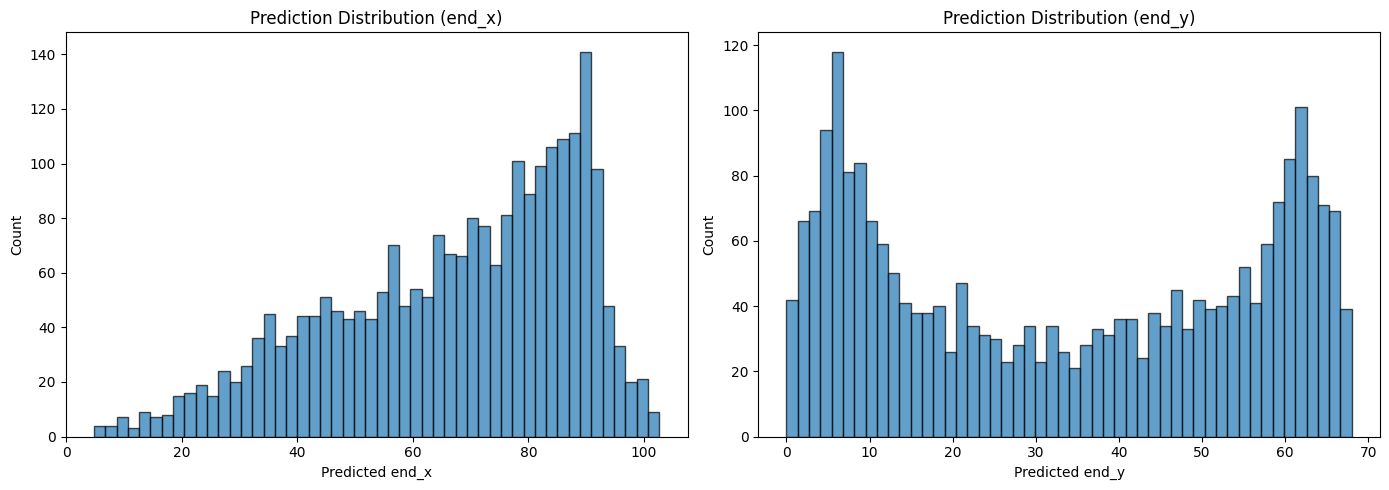

In [15]:
# 예측 분포 확인
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(pred_x, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Predicted end_x')
axes[0].set_ylabel('Count')
axes[0].set_title('Prediction Distribution (end_x)')

axes[1].hist(pred_y, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Predicted end_y')
axes[1].set_ylabel('Count')
axes[1].set_title('Prediction Distribution (end_y)')

plt.tight_layout()
plt.show()